In [1]:
import os
import time
import sys
import json
import numpy as np
import ipyvolume as ipv
from pathlib import Path
import pandas as pd
import random
from datetime import datetime

from tyssue import Sheet, config
from tyssue.io import hdf5
from tyssue.generation import ellipsoid_sheet
from tyssue.draw import sheet_view
from tyssue.draw.ipv_draw import view_ipv
from tyssue.draw.plt_draw import quick_edge_draw
from tyssue.dynamics import effectors, units
from tyssue.dynamics.sheet_gradients import height_grad
from tyssue.dynamics.factory import model_factory
from tyssue.solvers.sheet_vertex_solver import Solver
from tyssue.topology.sheet_topology import remove_face
from tyssue.utils.decorators import do_undo
from tyssue.utils import to_nd
from tyssue.io import hdf5
from tyssue import SheetGeometry as geom

import matplotlib.pyplot as plt

%matplotlib inline

SIM_DIR = Path('/home/admin-suz/Documents/Simulations/')

from polarity.solver import find_energy_min

In [2]:
class LineTensionPolarity(effectors.AbstractEffector):

    dimensions = units.line_tension
    magnitude = "line_tension_polarity"
    label = "Line tension with polarity"
    element = "edge"
    specs = {"edge": {"is_active", "line_tension", "C_a"}}

    spatial_ref = "mean_length", units.length

    @staticmethod
    def energy(eptm):
        return eptm.edge_df.eval(
            "line_tension" "* is_active" "* length" "* C_a"
        )  # accounts for half edges

    @staticmethod
    def gradient(eptm):
        grad_srce = -eptm.edge_df[eptm.ucoords] * to_nd(
            eptm.edge_df.eval("line_tension * is_active/2 * C_a"), len(eptm.coords)
        )
        grad_srce.columns = ["g" + u for u in eptm.coords]
        grad_trgt = -grad_srce
        return grad_srce, grad_trgt

In [3]:
EllipsoidBModel = model_factory(
    [
    effectors.FaceContractility,
    effectors.FaceVolumeElasticity,
    ], effectors.FaceAreaElasticity)

model = EllipsoidBModel


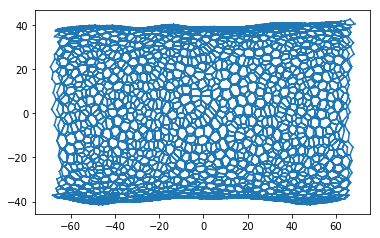

In [4]:
dsets = hdf5.load_datasets('../../tyssue/tyssue/stores/before_apoptosis.hf5',
                           data_names=['vert', 'edge', 'face'])


specs = config.geometry.cylindrical_sheet()
sheet = Sheet('emin', dsets, specs)

# Modify some initial value
sheet.settings['threshold_length'] = 1e-3
sheet.vert_df['radial_tension'] = 0.

fig, ax = quick_edge_draw(sheet, coords=list('zx'))

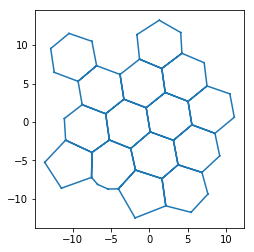

In [15]:
from tyssue.stores import stores_dir
from tyssue.config.geometry import cylindrical_sheet

h5store = os.path.join(stores_dir, "15_cells_patch.hf5")

datasets = hdf5.load_datasets(h5store, data_names=["face", "vert", "edge"])
specs = cylindrical_sheet()
sheet = Sheet("emin", datasets, specs)

# Modify some initial value
sheet.settings['threshold_length'] = 1e-3
sheet.vert_df['radial_tension'] = 0.

fig, ax = quick_edge_draw(sheet, coords=list('xy'))
sheet.get_opposite()

In [5]:
# Add column 'C_a' to face_df, which contains the total quantity of protein a in the cell
sheet.face_df['prefered_N_a'] = 1

# Add column 'C_a' to edge_df, whoch contains the quantity of protein along one edge
sheet.edge_df['C_a'] = 0
sheet.edge_df['N_a'] = 1/sheet.upcast_face('num_sides')
#sheet.edge_df['N_a'] = np.random.uniform(0,0.3, sheet.Ne)

faces_N_a = sheet.sum_face(sheet.edge_df['N_a'])
sheet.edge_df['N_a'] = (sheet.edge_df['N_a'] 
                        * sheet.upcast_face(sheet.face_df['prefered_N_a']/faces_N_a['N_a']))

sheet.edge_df['C_a'] = sheet.edge_df['N_a'] / sheet.edge_df.length
    
   
  
    
sheet.settings ['epsilon_0'] = 0.02
sheet.settings ['epsilon_1'] = 0.4
sheet.settings ['J'] = 1e-6
#sheet.settings ['lambda_c'] = 1

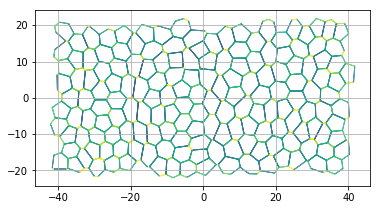

In [6]:
# Forme du tissu au debut
sheet2 = sheet.extract_bounding_box(y_boundary=[-0,100], x_boundary = [-20,20], z_boundary=[-40,40])
fig, ax = sheet_view(sheet2, edge={'color_range': [0,0.1],'color':sheet2.edge_df.C_a, 'width':1}, 
                     vert={'visible':False}, coords = ['z','x'])

In [7]:
import time 
tmps1=time.time()
solver_kw = {'minimize': {'method': 'SLSQP',
                          'options': {'ftol': 1e-2,
                                     'maxiter': 2}}}
                                      #'gtol': 1e-8}}}
res = find_energy_min(sheet, geom, model, **solver_kw)
print(res)
tmps2=time.time()-tmps1
#print (tmps2)


     fun: -145.50942284906048
     jac: array([ 2.20720768e-07,  2.31575515e-07, -1.97115023e-01, ...,
       -1.98847663e-04, -1.13591442e-02, -1.38186928e-01])
 message: 'Iteration limit exceeded'
    nfev: 3
     nit: 3
    njev: 3
  status: 9
 success: False
       x: array([5.33661657e-14, 5.75446808e-14, 2.20720772e-01, ...,
       2.79294187e-03, 8.64315458e-03, 2.97670925e-01])


In [14]:
tmps2

17030.632348060608

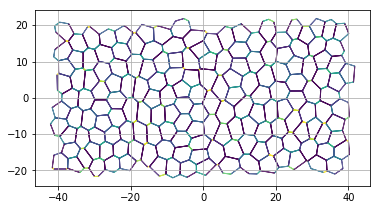

In [10]:
sheet2 = sheet.extract_bounding_box(y_boundary=[-0,100], x_boundary = [-20,20], z_boundary=[-40,40])
fig, ax = sheet_view(sheet2, edge={'color_range': [0,0.3],'color':sheet2.edge_df.C_a, 'width':1, 'alpha':0.4}, 
                     vert={'visible':False}, coords = ['z','x'])

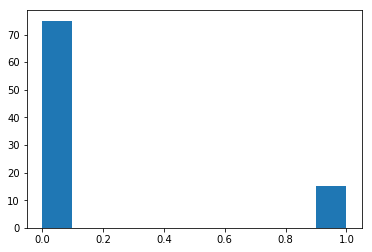

In [13]:
H = plt.hist (sheet.edge_df.C_a*sheet.edge_df.length)

In [ ]:
sheet.vert_df.z = sheet.vert_df.z *0.7
geom.update_all(sheet)


In [ ]:
fig, ax = sheet_view(sheet, edge={'color_range': [0,0.3],'color':sheet.edge_df.C_a, 'width':1}, 
                     vert={'visible':False}, coords = ['z','x'])

In [ ]:
import time 
tmps1=time.time()
solver_kw = {'minimize': {'method': 'SLSQP',
                          'options': {'ftol': 1e-8}}}
                                      #'gtol': 1e-8}}}
res = find_energy_min(sheet, geom, model, **solver_kw)
print(res)
tmps2=time.time()-tmps1
#print (tmps2)


In [ ]:
fig, ax = sheet_view(sheet, edge={'color_range': [0,0.3],'color':sheet.edge_df.C_a, 'width':1},
                     vert={'visible':False}, coords = ['z','x'])

In [ ]:
import time 
tmps1=time.time()
solver_kw = {'minimize': {'method': 'SLSQP',
                          'options': {'ftol': 1e-8}}}
                                      #'gtol': 1e-8}}}
res = find_energy_min(sheet, geom, model, **solver_kw)
print(res)
tmps2=time.time()-tmps1
#print (tmps2)


In [ ]:
fig, ax = sheet_view(sheet, edge={'color_range': [0,0.3],'color':sheet.edge_df.C_a, 'width':1},
                     vert={'visible':False}, coords = ['z','x'])

In [ ]:
import time 
tmps1=time.time()
solver_kw = {'minimize': {'method': 'SLSQP',
                          'options': {'ftol': 1e-8}}}
                                      #'gtol': 1e-8}}}
res = find_energy_min(sheet, geom, model, **solver_kw)
print(res)
tmps2=time.time()-tmps1
#print (tmps2)


In [ ]:
sheet2 = sheet.extract_bounding_box(y_boundary=[0,50], x_boundary = [-20,20], z_boundary=[-40,40])
fig, ax = sheet_view(sheet2, edge={'color_range': [0,0.3],'color':sheet2.edge_df.C_a, 'width':1}, 
                     vert={'visible':False}, coords = ['z','x'])

In [ ]:
print(sheet.edge_df.C_a.head(10)

In [ ]:
print(sheet.edge_df.C_a.min())

In [13]:
sheet.get_opposite()

In [14]:
from scipy import optimize
from polarity.solver import chem_energy, chem_grad

optimize.check_grad(chem_energy, chem_grad, sheet.edge_df['C_a'], sheet)

5.269632677118945

In [15]:
sheet.Ne

272

In [ ]:
r = optimize.approx_fprime(sheet.edge_df['C_a'], chem_energy, 1e-6, sheet)
r

In [41]:
faces_C_a = sheet.sum_face(sheet.edge_df['C_a'])

In [42]:
faces_C_a

,C_a
face,
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0
5,1.0
6,1.0
7,1.0
8,1.0


In [ ]:
C1_ij.head(10)

In [ ]:
C1_jm.head(10)